In [1]:
#     !    IMPORTANT SETTINGS     !
#Set to True to enable grid search for prediction question 1
enable_grid=False

#Set to true to take a random sample for inference question 5. Will take 5-6 hours to run API call on the full dataset if not. 
random_sample = True

In [2]:
#Install pyspark if not already installed
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark

fi

bash: line 6: syntax error near unexpected token `fi'
bash: line 6: `fi'


In [3]:
#Import necessary Python functions
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import requests
import json

#Import necessary PySpark functions
from pyspark import SparkConf, SparkContext, SparkFiles

from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.types import StructType, StructField, FloatType, \
    IntegerType, StringType, ArrayType
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, explode

from pyspark.ml import feature, Pipeline, classification, regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler

#Build the spark session, set checkpoint dir
spark = SparkSession.builder.getOrCreate()
spark_context = spark.sparkContext
spark_context.setCheckpointDir('/content')
sqlContext = SQLContext(spark_context)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [55]:
#Import the dataset from the web
!wget https://raw.githubusercontent.com/zakhikhan/dataset/main/cal_housing.data

#Build the schema
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medianage", FloatType(), nullable=True),
    StructField("rooms", FloatType(), nullable=True),
    StructField("bedrooms", FloatType(), nullable=True),
    StructField("population", FloatType(), nullable=True),
    StructField("households", FloatType(), nullable=True),
    StructField("medianincome", FloatType(), nullable=True),
    StructField("medianhousevalue", FloatType(), nullable=True)]
)

#Assign the dataset to the 'df' variable
housing_california = '/content/cal_housing.data'
df = spark.read.csv(path = housing_california, schema = schema)
df.show(5)

--2022-05-05 16:43:55--  https://raw.githubusercontent.com/zakhikhan/dataset/main/cal_housing.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071484 (2.0M) [text/plain]
Saving to: ‘cal_housing.data.5’

cal_housing.data.5  100%[===================>]   1.97M  --.-KB/s    in 0.06s   

2022-05-05 16:43:56 (33.4 MB/s) - ‘cal_housing.data.5’ saved [2071484/2071484]

+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|-122.23|37.88|     41.0| 880.0|   129.0|     322.0|     126.0|      8.3252|        452600.0|
|-122.22|37.86|     21.

In [7]:
# show the dataframe columns
df.columns

['long',
 'lat',
 'medianage',
 'rooms',
 'bedrooms',
 'population',
 'households',
 'medianincome',
 'medianhousevalue']

In [33]:
df.select('population','bedrooms').show(10)

+----------+--------+
|population|bedrooms|
+----------+--------+
|     322.0|   129.0|
|    2401.0|  1106.0|
|     496.0|   190.0|
|     558.0|   235.0|
|     565.0|   280.0|
|     413.0|   213.0|
|    1094.0|   489.0|
|    1157.0|   687.0|
|    1206.0|   665.0|
|    1551.0|   707.0|
+----------+--------+
only showing top 10 rows



In [34]:
result_df = df.groupBy("medianage").count().sort("medianage", ascending=False)
result_df.show(10)


+---------+-----+
|medianage|count|
+---------+-----+
|     52.0| 1273|
|     51.0|   48|
|     50.0|  136|
|     49.0|  134|
|     48.0|  177|
|     47.0|  198|
|     46.0|  245|
|     45.0|  294|
|     44.0|  356|
|     43.0|  353|
+---------+-----+
only showing top 10 rows



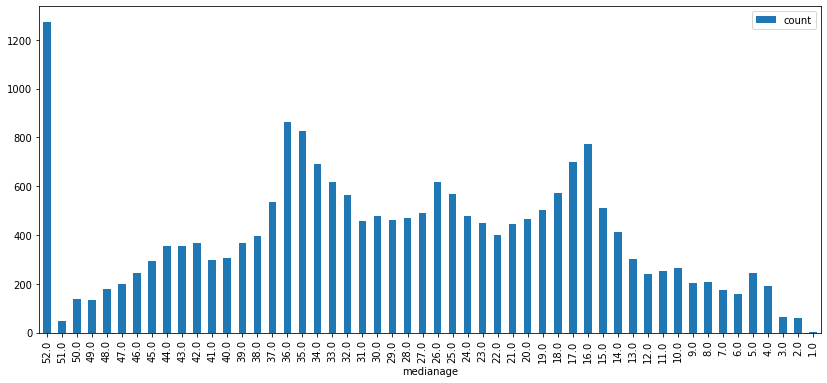

In [35]:
result_df.toPandas().plot.bar(x='medianage',figsize=(14, 6))

Most of the residents are either in their youth or they settle here during their senior years. 

In [36]:
df.describe()

DataFrame[summary: string, long: string, lat: string, medianage: string, rooms: string, bedrooms: string, population: string, households: string, medianincome: string, medianhousevalue: string]

In [37]:
(df.describe().select(
                    "summary",
                    F.round("medianage", 4).alias("medianage"),
                    F.round("rooms", 4).alias("rooms"),
                    F.round("bedrooms", 4).alias("bedrooms"),
                    F.round("population", 4).alias("population"),
                    F.round("households", 4).alias("households"),
                    F.round("medianincome", 4).alias("medianincome"),
                    F.round("medianhousevalue", 4).alias("medianhousevalue"))
                    .show())

+-------+---------+---------+--------+----------+----------+------------+----------------+
|summary|medianage|    rooms|bedrooms|population|households|medianincome|medianhousevalue|
+-------+---------+---------+--------+----------+----------+------------+----------------+
|  count|  20640.0|  20640.0| 20640.0|   20640.0|   20640.0|     20640.0|         20640.0|
|   mean|  28.6395|2635.7631| 537.898| 1425.4767|  499.5397|      3.8707|     206855.8169|
| stddev|  12.5856|2181.6153|421.2479| 1132.4621|  382.3298|      1.8998|     115395.6159|
|    min|      1.0|      2.0|     1.0|       3.0|       1.0|      0.4999|         14999.0|
|    max|     52.0|  39320.0|  6445.0|   35682.0|    6082.0|     15.0001|        500001.0|
+-------+---------+---------+--------+----------+----------+------------+----------------+



Looking at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize your dataset.

With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.

- we shouldn't care about missing values; all zero values have been excluded from the data set.
- We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.
- There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
- Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

# **Feature Engineering**

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

- Rooms per household which refers to the number of rooms in households per block group;
- Population per household, which basically gives us an indication of how many people live in households per block group; And
- Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group



In [58]:
from pyspark.sql.functions import *
df.select([count(when(isnull(c), c))\
.alias(c) for c in df.columns]).show()

+----+---+---------+-----+--------+----------+----------+------------+----------------+
|long|lat|medianage|rooms|bedrooms|population|households|medianincome|medianhousevalue|
+----+---+---------+-----+--------+----------+----------+------------+----------------+
|   0|  0|        0|    0|       0|         0|         0|           0|               0|
+----+---+---------+-----+--------+----------+----------+------------+----------------+



# **Inference**

#### 1. Which variables are most influential on median home price? i.e. how much does median home price change with a change in each variable?

In [41]:
#Build an LR pipelines
from pyspark.ml import regression
from pyspark.ml.feature import StandardScaler
housing_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['medianage', 'rooms', 'bedrooms', 'population', 'households','medianincome'], 
                                              outputCol='features'),
                                StandardScaler(inputCol="features",outputCol="scaled_features",
                                                 withStd=True, withMean=True),
                                regression.LinearRegression(labelCol='medianhousevalue', featuresCol='scaled_features')])

In [42]:
#Fit the pipe
housing_pipe_fitted = housing_pipe.fit(df)

In [43]:
#Split the data into training and test datasets
training, validation, test = df.randomSplit([0.6, 0.3, 0.1], 0)

In [44]:
#Get coefficients
coefficients = housing_pipe_fitted.stages[-1].coefficients

labels = housing_pipe_fitted.stages[0].getInputCols()

coefficients_df = pd.DataFrame(list(zip(labels, coefficients)), columns = ['coefficient','value']).sort_values(by='value', ascending=False)
coefficients_df

,coefficient,value
5,medianincome,0.906172
4,households,0.479661
2,bedrooms,0.423054
0,medianage,0.236727
3,population,-0.402009
1,rooms,-0.428524


####2. Does the impact of median income on median home value remain relatively constant throughout the dataset, or are there outliers? What might those outliers tell us?

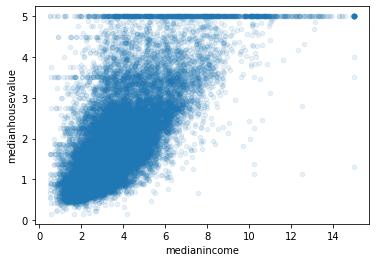

In [45]:
df2=df.toPandas()

df2.plot(kind='scatter',x='medianincome',y='medianhousevalue',alpha=0.1)

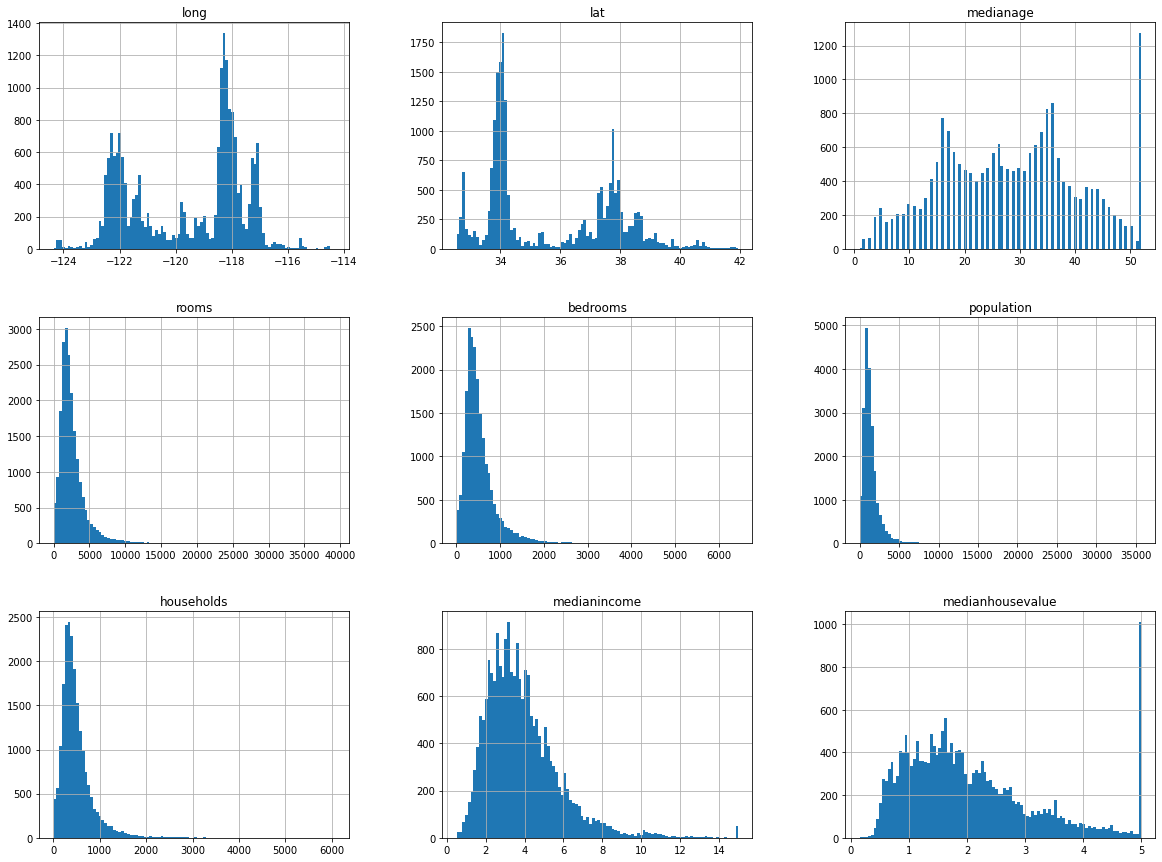

In [46]:
df2.hist(bins=100, figsize = (20, 15))
plt.show()

In [47]:
df2.describe()

,long,lat,medianage,rooms,bedrooms,population,households,medianincome,medianhousevalue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569115,35.631866,28.639486,2635.758789,537.898010,1425.477905,499.539673,3.870662,2.068558
std,2.003539,2.135956,12.585629,2181.604736,421.247284,1132.460815,382.329773,1.899820,1.153956
min,-124.349998,32.540001,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.149990
25%,-121.800003,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,1.196000
50%,-118.489998,34.259998,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,1.797000
75%,-118.010002,37.709999,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,2.647250
max,-114.309998,41.950001,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,5.000010


####3. Can rooms per person function as a predictor variable ? Do home values tend to be higher where populations are more concentrated?

In [66]:
#Create the derived variables
df6 = df.withColumn("rooms_per_person",col('rooms')/col('population'))

In [67]:
df6.show(10)

+-------+-----+---------+------+--------+----------+----------+------------+----------------+------------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|  rooms_per_person|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+------------------+
|-122.23|37.88|     41.0| 880.0|   129.0|     322.0|     126.0|      8.3252|           4.526| 2.732919254658385|
|-122.22|37.86|     21.0|7099.0|  1106.0|    2401.0|    1138.0|      8.3014|           3.585|2.9566847147022073|
|-122.24|37.85|     52.0|1467.0|   190.0|     496.0|     177.0|      7.2574|           3.521|2.9576612903225805|
|-122.25|37.85|     52.0|1274.0|   235.0|     558.0|     219.0|      5.6431|           3.413| 2.283154121863799|
|-122.25|37.85|     52.0|1627.0|   280.0|     565.0|     259.0|      3.8462|           3.422| 2.879646017699115|
|-122.25|37.85|     52.0| 919.0|   213.0|     413.0|     193.0|      4.0368|           2.697| 2.

In [69]:
#Build the pipe
housing_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['medianage', 'rooms', 'bedrooms', 'population', 'households','medianincome','rooms_per_person'], 
                                              outputCol='features'),
                                StandardScaler(inputCol="features",outputCol="scaled_features",
                                                 withStd=True, withMean=True),
                                regression.LinearRegression(labelCol='medianhousevalue', featuresCol='scaled_features')])

In [70]:
#Fit the pipeline
housing_pipe_fitted = housing_pipe.fit(df6)

#Get coefficients
coefficients = housing_pipe_fitted.stages[-1].coefficients

#Create a dataframe of coefficients
labels = housing_pipe_fitted.stages[0].getInputCols()

coefficients_df = pd.DataFrame(list(zip(labels, coefficients)), columns = ['coefficient','value']).sort_values(by='value', ascending=False)
coefficients_df

,coefficient,value
5,medianincome,0.896932
4,households,0.573176
2,bedrooms,0.328645
0,medianage,0.238498
6,rooms_per_person,0.061066
3,population,-0.363464
1,rooms,-0.465089


####4.   Is there a positive correlation between the number of non-bedroom rooms and median home value? 

In [63]:
#Create the derived variable
df7 = df.withColumn("pct_bedrooms",col('bedrooms')/col('rooms'))

In [64]:
#Build the pipe
housing_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['medianage', 'rooms', 'bedrooms', 'population', 'households','medianincome','pct_bedrooms'], 
                                              outputCol='features'),
                                StandardScaler(inputCol="features",outputCol="scaled_features",
                                                 withStd=True, withMean=True),
                                regression.LinearRegression(labelCol='medianhousevalue', featuresCol='scaled_features')])

In [65]:
#Fit the pipe
housing_pipe_fitted = housing_pipe.fit(df7)

#Get coefficients
coefficients = housing_pipe_fitted.stages[-1].coefficients

labels = housing_pipe_fitted.stages[0].getInputCols()

coefficients_df = pd.DataFrame(list(zip(labels, coefficients)), columns = ['coefficient','value'])
coefficeients_df = coefficients_df.sort_values(by='value', ascending=False)
coefficients_df

labels = housing_pipe_fitted.stages[0].getInputCols()

coefficients_df = pd.DataFrame(list(zip(labels, coefficients)), columns = ['coefficient','value']).sort_values(by='value', ascending=False)
coefficients_df

,coefficient,value
5,medianincome,0.976166
4,households,0.529870
6,pct_bedrooms,0.244272
0,medianage,0.227177
2,bedrooms,0.031590
1,rooms,-0.046851
3,population,-0.443209


####5.   If we partition the dataset between urban and suburban/rural locations, do our relationships between predictor and target variables hold true?

In [7]:
#testing it to get just the city name

ca_cities = ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach', 'Oakland', 'Bakersfield', 'Anaheim', 'Stockton', 'Riverside', 'Santa Ana', 'Irvine', 'Chula Vista', 'Fremont', 'Santa Clarita', 'San Bernadino', 'Modesto', 'Moreno Valley', 'Fontana', 'Oxnard', 'Huntington Beach', 'Glendale', 'Santa Rosa', 'Elk Grove', 'Ontario', 'Rancho Cucamonga', 'Oceanside', 'Lancaster', 'Garden Grove', 'Palmdale', 'Salinas', 'Hayward', 'Corona', 'Sunnyvale', 'Pomona', 'Escondido']

#Function to execute the API call
def executeRestApi(longitude, latitude):
  #If a random sample is not taken, the function needs to sleep for 1s between API calls or the timeout will be triggered
  if random_sample == False:
    time.sleep(1)
  else:
    pass
  url = f"https://nominatim.openstreetmap.org/reverse?lat={latitude}&lon={longitude}&format=json"

  # Make API request, get response object back, create dataframe from above schema.
  res = requests.get(url)
  data=res.json()
  try:
    city = data["address"]["city"]
    if city in ca_cities:
      return 1
    else:
      return 0
  except:
    try:
      city = data["address"]["town"]
      if city in ca_cities:
        return 1
      else:
        return 0
    except:
      try:
        city = data["address"]["village"]
        if city in ca_cities:
          return 1
        else:
          return 0
      except:
        try:
          city = data["address"]["suburb"]
          if city in ca_cities:
            return 1
          else:
            return 0
        except:
          return 2

udf_executeRestApi = udf(executeRestApi)


In [14]:
#Note: Expect this cell to take ~20 minutes to run if random_sample is True, else expect 5-6 hours (may need local runtime or Colab Pro)
#You can change the fraction variable to a smaller number make it run faster, but might not give you a statisctically significant sample
fraction = .05

df9 = df
#Take a random sample, if enabled
if random_sample:
  df9=df9.sample(withReplacement=False, fraction=fraction)
else:
  pass

#Function to make the request
result_df = df9.withColumn("urban", udf_executeRestApi(col("long"), col("lat"))).checkpoint(eager=True)

In [9]:
result_df.show()

+-------+-----+---------+-------+--------+----------+----------+------------+----------------+-----+
|   long|  lat|medianage|  rooms|bedrooms|population|households|medianincome|medianhousevalue|urban|
+-------+-----+---------+-------+--------+----------+----------+------------+----------------+-----+
|-122.26|37.83|     52.0| 1443.0|   311.0|     660.0|     292.0|      3.0125|        184400.0|    1|
|-122.16|37.79|     22.0|12842.0|  2048.0|    4985.0|    1967.0|      5.9849|        371000.0|    1|
|-122.34|37.88|     37.0| 3061.0|   930.0|    2556.0|     924.0|      1.7375|        350000.0|    0|
|-122.28|37.78|     29.0| 5154.0|  1394.0|    3741.0|    1273.0|      2.5762|        173400.0|    0|
|-122.07|37.69|     29.0| 2304.0|   618.0|    1021.0|     552.0|      2.5362|        203800.0|    0|
|-122.01|37.53|     27.0| 1890.0|   303.0|     889.0|     314.0|      5.7057|        287600.0|    0|
| -120.9| 38.2|     16.0| 3120.0|   641.0|    1319.0|     526.0|      2.0472|         93200

In [10]:
#Filter to only urban
cities_df = result_df.where(result_df.urban == 1)
cities_df_pd = cities_df.toPandas()
num_urban = len(cities_df_pd)
print (f"{num_urban} urban datapoints")

#Filter to only rural/suburban
noncities_df = result_df.where(result_df.urban==0)
noncities_df_pd = noncities_df.toPandas()
num_nonurban= len(noncities_df_pd)
print (f"{num_nonurban} non-urban datapoints")

#Check for errors
errors_df_pd = result_df.where(result_df.urban==2).toPandas()
num_errors = len(errors_df_pd)
print (f"{num_errors} errors found")


33 urban datapoints
51 non-urban datapoints
14 errors found


In [13]:
errors_df_pd.head(num_errors)

,long,lat,medianage,rooms,bedrooms,population,households,medianincome,medianhousevalue,urban
0,-120.900002,38.200001,16.0,3120.0,641.0,1319.0,526.0,2.0472,93200.0,2
1,-120.870003,38.709999,13.0,2692.0,470.0,1302.0,420.0,4.0000,167400.0,2
2,-118.419998,37.360001,18.0,2281.0,520.0,1425.0,465.0,1.7388,54400.0,2
3,-121.699997,36.840000,19.0,2511.0,465.0,1551.0,450.0,4.9107,231900.0,2
4,-120.349998,39.340000,29.0,1986.0,474.0,337.0,100.0,4.0278,95800.0,2
5,-121.360001,38.610001,37.0,2191.0,394.0,951.0,362.0,3.8882,159500.0,2
6,-121.199997,38.669998,26.0,1546.0,287.0,773.0,299.0,2.9803,115400.0,2
7,-117.139999,33.070000,12.0,9302.0,1603.0,4074.0,1504.0,4.3513,199600.0,2
8,-121.269997,37.880001,43.0,968.0,249.0,664.0,240.0,1.6458,83600.0,2
9,-121.190002,38.130001,27.0,2400.0,435.0,1085.0,444.0,3.7687,165200.0,2


In [12]:
#check all errors, manually verify all are rural/suburban areas
for i in range(len(errors_df_pd)): 
  longitude= errors_df_pd.long[i]
  latitude= errors_df_pd.lat[i]
  url = f"https://nominatim.openstreetmap.org/reverse?lat={latitude}&lon={longitude}&format=json"
  # Make API request, get response object back, create dataframe from above schema.
  res = requests.get(url)
  data=res.json()
  print(data)

{'place_id': 99285561, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 10308990, 'lat': '38.20122782030721', 'lon': '-120.8998441360988', 'display_name': 'Camanche Parkway South, South Camanche Shore, Calaveras County, California, 95225, United States', 'address': {'road': 'Camanche Parkway South', 'hamlet': 'South Camanche Shore', 'county': 'Calaveras County', 'state': 'California', 'ISO3166-2-lvl4': 'US-CA', 'postcode': '95225', 'country': 'United States', 'country_code': 'us'}, 'boundingbox': ['38.198543', '38.2267261', '-120.905144', '-120.878975']}
{'place_id': 98496671, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 10337063, 'lat': '38.7121445', 'lon': '-120.8700991', 'display_name': 'Sundance Trail, El Dorado County, California, 95667-8217, United States', 'address': {'road': 'Sundance Trail', 'county': 'El Dorado County', 'state': 'California', '

In [15]:
#Refilter "errors" back in
noncities_df = result_df.where(result_df.urban!=1)
noncities_df_pd = noncities_df.toPandas()
num_nonurban= len(noncities_df_pd)
print (f"{num_nonurban} non-urban datapoints")

4 non-urban datapoints


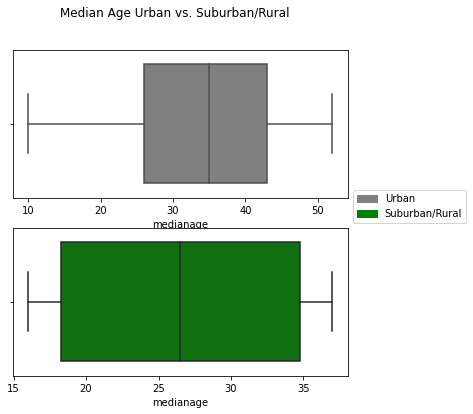

In [17]:
#Plot median age

#test ax
fig, ax = plt.subplots(2, 1, figsize=(6,6))
#ax = fig.add_subplot(2, 1)
sns.boxplot(x=cities_df_pd['medianage'],ax=ax[0],color='grey')
sns.boxplot(x=noncities_df_pd['medianage'],ax=ax[1],color='green')

fig.suptitle('Median Age Urban vs. Suburban/Rural')
gray_patch = mpatches.Patch(color='grey', label='Urban')
green_patch = mpatches.Patch(color='green', label='Suburban/Rural')
plt.legend(handles=[gray_patch,green_patch], loc = 3, bbox_to_anchor = (1,1))

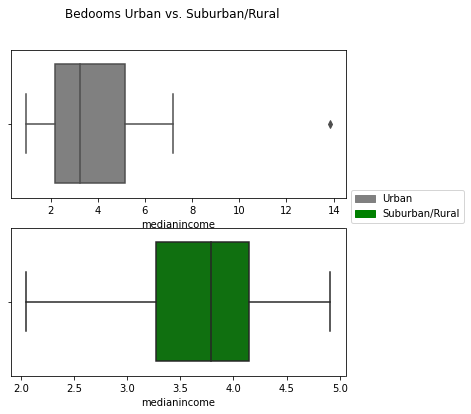

In [18]:
#Plot median income

#test ax
fig, ax = plt.subplots(2, 1, figsize=(6,6))
#ax = fig.add_subplot(2, 1)
sns.boxplot(x=cities_df_pd['medianincome'],ax=ax[0],color='grey')
sns.boxplot(x=noncities_df_pd['medianincome'],ax=ax[1],color='green')

fig.suptitle('Bedooms Urban vs. Suburban/Rural')
gray_patch = mpatches.Patch(color='grey', label='Urban')
green_patch = mpatches.Patch(color='green', label='Suburban/Rural')
plt.legend(handles=[gray_patch,green_patch], loc = 3, bbox_to_anchor = (1,1))

(-100.0, 12000.0)

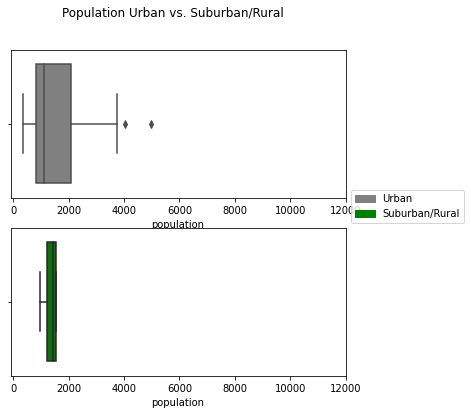

In [20]:
#Plot population

#test ax
fig, ax = plt.subplots(2, 1, figsize=(6,6))



#ax = fig.add_subplot(2, 1)
plot1= sns.boxplot(x=cities_df_pd['population'],ax=ax[0],color='grey')
plot2= sns.boxplot(x=noncities_df_pd['population'],ax=ax[1],color='green')

fig.suptitle('Population Urban vs. Suburban/Rural')
gray_patch = mpatches.Patch(color='grey', label='Urban')
green_patch = mpatches.Patch(color='green', label='Suburban/Rural')
plt.legend(handles=[gray_patch,green_patch], loc = 3, bbox_to_anchor = (1,1))
plot1.set_xlim([-100,12000])
plot2.set_xlim([-100,12000])

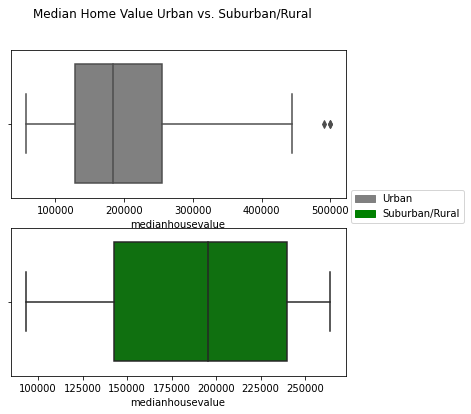

In [21]:
#Plot median house value

#test ax
fig, ax = plt.subplots(2, 1, figsize=(6,6))



#ax = fig.add_subplot(2, 1)
plot1= sns.boxplot(x=cities_df_pd['medianhousevalue'],ax=ax[0],color='grey')
plot2= sns.boxplot(x=noncities_df_pd['medianhousevalue'],ax=ax[1],color='green')

fig.suptitle('Median Home Value Urban vs. Suburban/Rural')
gray_patch = mpatches.Patch(color='grey', label='Urban')
green_patch = mpatches.Patch(color='green', label='Suburban/Rural')
plt.legend(handles=[gray_patch,green_patch], loc = 3, bbox_to_anchor = (1,1))
#plot1.set_xlim([-100,12000])
#plot2.set_xlim([-100,12000])

In [23]:
#Build a pipe

compare_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['medianage', 'rooms', 'bedrooms', 'population', 'households','medianincome'], 
                                              outputCol='features'),
                                StandardScaler(inputCol="features",outputCol="scaled_features",
                                                 withStd=True, withMean=True),
                                regression.LinearRegression(labelCol='medianhousevalue', featuresCol='scaled_features')])

In [24]:
#Fit the pipes and get coefficients

#Fit the pipeline
urban_pipe = compare_pipe.fit(cities_df)
nonurban_pipe = compare_pipe.fit(noncities_df)

#Get coefficients
urban_coefficients = urban_pipe.stages[-1].coefficients
nonurban_coefficients = nonurban_pipe.stages[-1].coefficients

labels = urban_pipe.stages[0].getInputCols()

urban_coefficients_df = pd.DataFrame(list(zip(labels, urban_coefficients)), columns = ['coefficient','value']).sort_values(by='value', ascending=False, key=abs)
nonurban_coefficients_df= pd.DataFrame(list(zip(labels, nonurban_coefficients)), columns = ['coefficient','value']).sort_values(by='value', ascending=False, key=abs)

In [25]:
#Display the coefficients
display(urban_coefficients_df, nonurban_coefficients_df)

,coefficient,value
2,bedrooms,269811.249782
4,households,-141708.164459
5,medianincome,98245.238161
3,population,-74995.303253
1,rooms,-44956.023620
0,medianage,17622.742416


,coefficient,value
5,medianincome,45450.313607
0,medianage,38681.917123
3,population,38392.637926
4,households,20134.179421
1,rooms,-7477.925718
2,bedrooms,5352.926564


# **Prediction**

####1. Given the other variables present in the dataset, can we predict the price of an unseen home?

In [30]:
df.columns

['long',
 'lat',
 'medianage',
 'rooms',
 'bedrooms',
 'population',
 'households',
 'medianincome',
 'medianhousevalue',
 'roomsperhousehold',
 'populationperhousehold',
 'bedroomsperhousehold']

In [31]:
df = (df.withColumn("roomsperhousehold", F.round(col("rooms")/col("households"), 2))
                  .withColumn("populationperhousehold", F.round(col("population")/col("households"), 2))
                  .withColumn("bedroomsperhousehold", F.round(col("bedrooms")/col("rooms"), 2)))

In [32]:
df.show(5)

+-------+-----+---------+------+--------+----------+----------+------------+----------------+-----------------+----------------------+--------------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|roomsperhousehold|populationperhousehold|bedroomsperhousehold|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+-----------------+----------------------+--------------------+
| -120.9| 38.2|     16.0|3120.0|   641.0|    1319.0|     526.0|      2.0472|         93200.0|             5.93|                  2.51|                0.21|
|-118.08|34.12|     34.0|2921.0|   641.0|    1541.0|     562.0|      3.6827|        264100.0|              5.2|                  2.74|                0.22|
| -118.2|33.83|     35.0|3737.0|   613.0|    1305.0|     583.0|      7.2096|        490300.0|             6.41|                  2.24|                0.16|
| -121.7|36.84|     19.0|2511.0|   465.0|    1551.0|     450.0| 

In [33]:
df_new = df.select("medianhousevalue", 
                "bedrooms", 
                "population", 
                "households", 
                "medianincome", 
                "roomsperhousehold", 
                "populationperhousehold", 
                "bedroomsperhousehold")

In [34]:
featureCols = ["bedrooms", "population", "households", "medianincome", "roomsperhousehold", "populationperhousehold", "bedroomsperhousehold"]

In [35]:
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 
assembled_df = assembler.transform(df_new)
assembled_df.show(10, truncate=False)

+----------------+--------+----------+----------+------------+-----------------+----------------------+--------------------+------------------------------------------------------+
|medianhousevalue|bedrooms|population|households|medianincome|roomsperhousehold|populationperhousehold|bedroomsperhousehold|features                                              |
+----------------+--------+----------+----------+------------+-----------------+----------------------+--------------------+------------------------------------------------------+
|93200.0         |641.0   |1319.0    |526.0     |2.0472      |5.93             |2.51                  |0.21                |[641.0,1319.0,526.0,2.0471999645233154,5.93,2.51,0.21]|
|264100.0        |641.0   |1541.0    |562.0     |3.6827      |5.2              |2.74                  |0.22                |[641.0,1541.0,562.0,3.6826999187469482,5.2,2.74,0.22] |
|490300.0        |613.0   |1305.0    |583.0     |7.2096      |6.41             |2.24                

In [36]:
# Split the data into train and test sets
train_data, test_data, val_data = assembled_df.randomSplit([.6,.2,.2], seed=1)

# Initialize the standardScaler
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
linearReg= LinearRegression(featuresCol= 'features_scaled', labelCol= "medianhousevalue")

lrpipe = Pipeline(stages=[standardScaler,linearReg])

#Grid Search Code
if enable_grid:
  lrpipe.getStages()
  grid = ParamGridBuilder().\
    addGrid(linearReg.elasticNetParam, [0, 1]).\
    addGrid(linearReg.regParam, [0.1, 0.01, 0.001, 0.0001]). \
    build()

  all_models = []
  for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = lrpipe.fit(train_data, grid[j])
    all_models.append(model)

  # # estimate the accuracy of each of them:
  evaluator=RegressionEvaluator(labelCol="medianhousevalue", predictionCol="prediction",metricName="mse")
  my_mses = [evaluator.evaluate(m.transform(val_data)) for m in all_models]
  my_mses
  best_model_idx = np.argmin(my_mses)
  print("best model index =", best_model_idx)
  best_model = all_models[best_model_idx]
  my_mses[best_model_idx]
  print(grid[best_model_idx])
else:
  pass

In [37]:
#Hard coded model with best params from grid search

linearReg= LinearRegression(featuresCol= 'features_scaled', labelCol= "medianhousevalue", regParam=0.0001, elasticNetParam=0.0)
best_lrpipe = Pipeline(stages=[standardScaler,linearReg])
model = best_lrpipe.fit(train_data)



In [38]:
#R2 score on test set
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medianhousevalue",metricName="r2")
r2_test = evaluator.evaluate(model.transform(test_data))
print("R2 score on test set: ", r2_test)

#RMSE on test set
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medianhousevalue",metricName="rmse")
rmse_test = evaluator.evaluate(model.transform(test_data))
print("RMSE on test set: ", rmse_test)

R2 score on test set:  -inf
RMSE on test set:  121973.19935742475


####2. Can we generate a relatively reliable prediction of home value given only longitude, latitude, total rooms, and total bedrooms?

In [39]:
df_new2 = df.select("medianhousevalue",
                "long", 
                "lat", 
                "rooms", 
                "bedrooms")

In [40]:
df_new2.show(5)

+----------------+-------+-----+------+--------+
|medianhousevalue|   long|  lat| rooms|bedrooms|
+----------------+-------+-----+------+--------+
|         93200.0| -120.9| 38.2|3120.0|   641.0|
|        264100.0|-118.08|34.12|2921.0|   641.0|
|        490300.0| -118.2|33.83|3737.0|   613.0|
|        231900.0| -121.7|36.84|2511.0|   465.0|
|        159500.0|-121.36|38.61|2191.0|   394.0|
+----------------+-------+-----+------+--------+



In [41]:
featureCols2 = ["long", "lat", "rooms", "bedrooms"]

In [42]:
assembler2 = VectorAssembler(inputCols=featureCols2, outputCol="features2") 
assembled_df2 = assembler2.transform(df_new2)
assembled_df2.show(10, truncate=False)

+----------------+-------+-----+------+--------+-----------------------------------------------------+
|medianhousevalue|long   |lat  |rooms |bedrooms|features2                                            |
+----------------+-------+-----+------+--------+-----------------------------------------------------+
|93200.0         |-120.9 |38.2 |3120.0|641.0   |[-120.9000015258789,38.20000076293945,3120.0,641.0]  |
|264100.0        |-118.08|34.12|2921.0|641.0   |[-118.08000183105469,34.119998931884766,2921.0,641.0]|
|490300.0        |-118.2 |33.83|3737.0|613.0   |[-118.19999694824219,33.83000183105469,3737.0,613.0] |
|231900.0        |-121.7 |36.84|2511.0|465.0   |[-121.69999694824219,36.84000015258789,2511.0,465.0] |
|159500.0        |-121.36|38.61|2191.0|394.0   |[-121.36000061035156,38.61000061035156,2191.0,394.0] |
+----------------+-------+-----+------+--------+-----------------------------------------------------+



In [43]:
# Initialize the standardScaler
standardScaler2 = StandardScaler(inputCol="features2", outputCol="features_scaled2")
# Fit the DataFrame to the scaler
scaled_df2 = standardScaler2.fit(assembled_df2).transform(assembled_df2)
scaled_df2.select("features2", "features_scaled2").show(10, truncate=False)

+-----------------------------------------------------+---------------------------------------------------------------------------+
|features2                                            |features_scaled2                                                           |
+-----------------------------------------------------+---------------------------------------------------------------------------+
|[-120.9000015258789,38.20000076293945,3120.0,641.0]  |[-68.48875174765259,17.045674566239907,5.2674979521631,5.617147769592865]  |
|[-118.08000183105469,34.119998931884766,2921.0,641.0]|[-66.89124755749813,15.225088648626704,4.931526127650133,5.617147769592865]|
|[-118.19999694824219,33.83000183105469,3737.0,613.0] |[-66.9592237004945,15.095685609171838,6.309179438215867,5.3717809403438785]|
|[-121.69999694824219,36.84000015258789,2511.0,465.0] |[-68.94194188156477,16.43881259370217,4.2393228711158795,4.074841985742094]|
|[-121.36000061035156,38.61000061035156,2191.0,394.0] |[-68.7493370470982,17

In [44]:
#splitting the data 
train_data, test_data = scaled_df2.randomSplit([0.8,0.2], seed=1)

In [54]:
linearReg= LinearRegression(featuresCol= 'features_scaled2', labelCol= "medianhousevalue")
#fit the model to the the training data
model=linearReg.fit(train_data)
#make predictions on the test set
predictions= model.transform(test_data)
# show the predicted values and the actual values
predictions.select("prediction" ,"medianhousevalue").show(10)

+-----------------+----------------+
|       prediction|medianhousevalue|
+-----------------+----------------+
|257575.7839124024|        490300.0|
+-----------------+----------------+



In [46]:
#R2 score on test set
r2_test= model.evaluate(test_data).r2
print("R2 score on test set: ", r2_test)

#RMSE on test set
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medianhousevalue",metricName="rmse")
rmse_test = evaluator.evaluate(predictions)
print("RMSE on test set: ", rmse_test)

R2 score on test set:  -inf
RMSE on test set:  232724.2160875976


####3. Can we use median age to help predict housing prices on its own?

In [59]:
df.show(5)

+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|   long|  lat|medianage| rooms|bedrooms|population|households|medianincome|medianhousevalue|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+
|-122.23|37.88|     41.0| 880.0|   129.0|     322.0|     126.0|      8.3252|           4.526|
|-122.22|37.86|     21.0|7099.0|  1106.0|    2401.0|    1138.0|      8.3014|           3.585|
|-122.24|37.85|     52.0|1467.0|   190.0|     496.0|     177.0|      7.2574|           3.521|
|-122.25|37.85|     52.0|1274.0|   235.0|     558.0|     219.0|      5.6431|           3.413|
|-122.25|37.85|     52.0|1627.0|   280.0|     565.0|     259.0|      3.8462|           3.422|
+-------+-----+---------+------+--------+----------+----------+------------+----------------+
only showing top 5 rows



In [60]:
# defining medianage as our label/predictor variable
df3 = df.select(df.medianage, df.medianhousevalue.alias('label'))
# split data into 70% training and 30% testing data
training, test = df3.randomSplit([0.7, 0.3], seed = 100)
# assembler to assemble the features into vector form
assembler = VectorAssembler().setInputCols(['medianage',]).setOutputCol('features')
trainingSet = assembler.transform(training)
# select only features column and label column since we have already vectorised our features
trainingSet = trainingSet.select("features","label")

In [61]:
# fit the training set to linear regression model
lr = LinearRegression()
lr_Model = lr.fit(trainingSet)
# assembler to assemble the features into vector form
testSet = assembler.transform(test)
# select only features column and label column since we have already vectorised our features
testSet = testSet.select("features", "label")
# fit the testing data into our linear regression model
testSet = lr_Model.transform(testSet)
testSet.show(truncate=False)

+--------+-------+------------------+
|features|label  |prediction        |
+--------+-------+------------------+
|[1.0]   |1.913  |1.8097990352332143|
|[2.0]   |1.142  |1.8193061102284969|
|[2.0]   |1.221  |1.8193061102284969|
|[2.0]   |1.367  |1.8193061102284969|
|[2.0]   |1.374  |1.8193061102284969|
|[2.0]   |1.459  |1.8193061102284969|
|[2.0]   |1.463  |1.8193061102284969|
|[2.0]   |1.648  |1.8193061102284969|
|[2.0]   |1.81   |1.8193061102284969|
|[2.0]   |1.967  |1.8193061102284969|
|[2.0]   |2.044  |1.8193061102284969|
|[2.0]   |2.101  |1.8193061102284969|
|[2.0]   |2.145  |1.8193061102284969|
|[2.0]   |2.208  |1.8193061102284969|
|[2.0]   |2.225  |1.8193061102284969|
|[2.0]   |2.985  |1.8193061102284969|
|[2.0]   |3.295  |1.8193061102284969|
|[2.0]   |4.841  |1.8193061102284969|
|[2.0]   |5.00001|1.8193061102284969|
|[3.0]   |0.832  |1.8288131852237797|
+--------+-------+------------------+
only showing top 20 rows



In [62]:
evaluator = RegressionEvaluator()
print(evaluator.evaluate(testSet, {evaluator.metricName: "r2"}))

0.012153001720492496


The r2 shows its a bad predictor